# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Lib for measureing execution time

In [2]:
%%bash

pip install ipython-autotime
%load_ext autotime

bash: line 3: fg: no job control


# Paragraph Identification

In [6]:
%%bash
cd '/content/drive/MyDrive/handwritten-text-recognition-for-apache-mxnet'

cd ..
#git clone https://github.com/usnistgov/SCTK

cd SCTK

pwd

export CXXFLAGS="-std=c++11" && make config
make all
make check
make install
make doc
cd -

/content/drive/MyDrive/SCTK
(mkdir -p bin)
(cd src && if test -f makefile ; then make config ; fi)
make[1]: Entering directory '/content/drive/MyDrive/SCTK/src'
(cd asclite && if test -f makefile ; then make config ; fi)
make[2]: Entering directory '/content/drive/MyDrive/SCTK/src/asclite'
(cd core && sh config.sh -prefix=`cd ../../.. && pwd`)
checking for g++... g++
checking for C++ compiler default output file name... a.out
checking whether the C++ compiler works... yes
checking whether we are cross compiling... no
checking for suffix of executables... 
checking for suffix of object files... o
checking whether we are using the GNU C++ compiler... yes
checking whether g++ accepts -g... yes
checking whether make sets $(MAKE)... yes
checking for gcc... gcc
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ANSI C... none needed
checking for main in -lm... yes
checking how to run the C preprocessor... gcc -E
ch

make[3]: execvp: ./asclite_test: Permission denied
make[3]: *** [check] Error 127
make[2]: *** [check] Error 2
make[1]: *** [checkFast] Error 2
make: *** [check] Error 2


In [7]:
%cd '/content/drive/MyDrive/SCTK'

/content/drive/MyDrive/SCTK


In [8]:
%%bash

pwd

export CXXFLAGS="-std=c++11" && make config
make all
make check
make install
make doc
cd -

/content/drive/MyDrive/SCTK
(mkdir -p bin)
(cd src && if test -f makefile ; then make config ; fi)
make[1]: Entering directory '/content/drive/MyDrive/SCTK/src'
(cd asclite && if test -f makefile ; then make config ; fi)
make[2]: Entering directory '/content/drive/MyDrive/SCTK/src/asclite'
(cd core && sh config.sh -prefix=`cd ../../.. && pwd`)
checking for g++... g++
checking for C++ compiler default output file name... a.out
checking whether the C++ compiler works... yes
checking whether we are cross compiling... no
checking for suffix of executables... 
checking for suffix of object files... o
checking whether we are using the GNU C++ compiler... yes
checking whether g++ accepts -g... yes
checking whether make sets $(MAKE)... yes
checking for gcc... gcc
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ANSI C... none needed
checking for main in -lm... yes
checking how to run the C preprocessor... gcc -E
ch

make[3]: execvp: ./asclite_test: Permission denied
make[3]: *** [check] Error 127
make[2]: *** [check] Error 2
make[1]: *** [checkFast] Error 2
make: *** [check] Error 2


## Change the Dir to Source dir

In [9]:
%cd '/content/drive/MyDrive/handwritten-text-recognition-for-apache-mxnet'

/content/drive/MyDrive/handwritten-text-recognition-for-apache-mxnet


In [10]:
pwd

'/content/drive/MyDrive/handwritten-text-recognition-for-apache-mxnet'

## Install the required Library

In [11]:
%%bash
# Install Required Softwares for Identifying Bounding Box of Handwritten Paragraph text
pip install -r '/content/drive/My Drive/handwritten-text-recognition-for-apache-mxnet/requirements.txt'

## Confirm for imports

In [12]:
### Test if modules are able to import
from ocr.utils.iam_dataset import IAMDataset

## Download Pretrained Model Param

In [13]:
%%bash 
python '/content/drive/My Drive/handwritten-text-recognition-for-apache-mxnet/get_models.py'

## TODO : DOWNLOAD MODEL PARAMS LOCALLY

## Required Imports for Bounding Box

In [14]:
import difflib
import importlib
import math
import random
import string

random.seed(123)

import cv2
import gluonnlp as nlp
import leven
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
import numpy as np
from skimage import transform as skimage_tf, exposure
from tqdm import tqdm

from ocr.utils.expand_bounding_box import expand_bounding_box
from ocr.utils.sclite_helper import ScliteHelper
from ocr.utils.word_to_line import sort_bbs_line_by_line, crop_line_images
from ocr.utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from ocr.utils.encoder_decoder import Denoiser, ALPHABET, encode_char, decode_char, EOS, BOS
from ocr.utils.beam_search import ctcBeamSearch

import ocr.utils.denoiser_utils
import ocr.utils.beam_search

importlib.reload(ocr.utils.denoiser_utils)
from ocr.utils.denoiser_utils import SequenceGenerator

importlib.reload(ocr.utils.beam_search)
from ocr.utils.beam_search import ctcBeamSearch


from ocr.paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform
from ocr.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from ocr.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding

from ocr.paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform


## Selct the CPU/GPU Based on the availability

In [15]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()
#ctx = mx.gpu(0)
ctx
random.seed(1)
ctx

cpu(0)

## Load testdata

In [61]:
test_ds = IAMDataset("form", credentials =(' ',' '),output_data="bb", output_parse_method="form",root = "/content/drive/My Drive/handwritten-text-recognition-for-apache-mxnet/dataset/iamdataset", train=False)
print("Number of training samples: {}".format(len(test_ds)))

Number of training samples: 232


## Paragraph segmentation

In [17]:
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
paragraph_segmentation_net.cnn.load_parameters("models/paragraph_segmentation2.params", ctx=ctx)
paragraph_segmentation_net.hybridize()

## Line/word segmentation

In [18]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation2.params")
word_segmentation_net.hybridize()

## Util Methods to Detect BB for Whole Paragraph and then at line level

In [56]:
def plot_paragraph(image):
  # Select Random Images
  # Plot Images
  fig, axs = plt.subplots(figsize=(12, 12))
  axs.imshow(image, cmap='Greys_r')



def plot_paragraph_boundingbox(images):
  for i, image in enumerate(images):

      # Plot Paragraph 
      fig, axs = plt.subplots(figsize=(12, 12))
      axs.imshow(image, cmap='Greys_r')


      # Plot Paragraph with Bounding Box 
      s_y, s_x = int(i/2), int(i%2)
      resized_image = paragraph_segmentation_transform(image, form_size)
      bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
      bb_predicted = bb_predicted[0].asnumpy()
      bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03,
                                            expand_bb_scale_y=0.03)
      predicted_bbs.append(bb_predicted)
      fig, axs = plt.subplots(figsize=(15, 15))
      axs.imshow(image, cmap='Greys_r')
      axs.set_title("{}".format(i))

      (x, y, w, h) = bb_predicted
      image_h, image_w = image.shape[-2:]
      (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
      rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
      axs.add_patch(rect)
      axs.axis('off')

#Crop the handwriting component out of the original IAM form.
def plot_paragraph_segmented(images):  

  for i, image in enumerate(images):
      segmented_paragraph_size = (700, 700)
      fig, axs = plt.subplots(figsize=(10, 10))
      s_y, s_x = int(i/2), int(i%2)

      bb = predicted_bbs[i]
      image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
      paragraph_segmented_images.append(image)
      
      axs.imshow(image, cmap='Greys_r')

      axs.axis('off')

def plot_word_segmentation(images):
  for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
      fig, axs = plt.subplots(figsize=(15, 9))

      s_y, s_x = int(i/2), int(i%2)

      predicted_bb = predict_bounding_boxes(
          word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

      predicted_words_bbs_array.append(predicted_bb)
      
      axs.imshow(paragraph_segmented_image, cmap='Greys_r')
      for j in range(predicted_bb.shape[0]):     
          (x, y, w, h) = predicted_bb[j]
          image_h, image_w = paragraph_segmented_image.shape[-2:]
          (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
          rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
          axs.add_patch(rect)
          axs.axis('off')


### Word to line image processing
#Algorithm to sort then group all words within a line together.

def plot_word_to_line(images):
  for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
      fig, axs = plt.subplots(figsize=(15, 9 ))
      s_y, s_x = int(i/2), int(i%2)
      #axs.imshow(paragraph_segmented_image, cmap='Greys_r')
      axs.axis('off')
      axs.set_title("{}".format(i))
      
      predicted_bbs = predicted_words_bbs_array[i]
      line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
      line_images = crop_line_images(paragraph_segmented_image, line_bbs)
      print ('Line image type = {} and Shape'.format(type(paragraph_segmented_image)))
      line_images_array.append(line_images)
      
      for line_bb in line_bbs:
          (x, y, w, h) = line_bb
          image_h, image_w = paragraph_segmented_image.shape[-2:]
          (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

          rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
          axs.add_patch(rect)

# PUTTING ALL TOGETHER

## Get Test_ds for inference

In [34]:
from PIL import Image

figs_to_plot = 1
images = []
n = 0
form_size = (1120, 800)
predicted_bbs = []


paragraph_segmented_images = []

# Required Variables for Word bb
min_c = 0.1
overlap_thres = 0.1
topk = 600

predicted_words_bbs_array = []

#Word to Line Variable declaration
line_images_array = []


for i in range(0, figs_to_plot):
    #n = int(random.random()*len(test_ds))
    n = 1
    image, _ = test_ds[n]
    images.append(image)
    # Save Paragraph Image 
    im = Image.fromarray(image)
    image_path = "/content/drive/My Drive/handwritten-text-recognition-for-apache-mxnet/images/paragraph_image_"+str(i)+'.png'
    im.save(image_path)

    #plot_paragraph(image)

#plot_paragraph_boundingbox(images)
#plot_paragraph_segmented(images)
#plot_word_segmentation(images)
#plot_word_to_line(images)

In [35]:
line_images_array = []

line_images_array

[]

In [36]:
from google.colab.patches import cv2_imshow

In [62]:
from PIL import Image

def predict_line_text(line_images_array):
  line_image_size = (60, 800)
  character_probs = []
  for line_images in line_images_array:
      form_character_prob = []
      for i, line_image in enumerate(line_images):
          #print('line_image type ={} and line_image shape : {}'.format(type(line_image),line_image.shape))
          #scipy.misc.imsave(i+'outfile.jpg', line_image)
          im = Image.fromarray(line_image)
          image_path = "/content/drive/My Drive/handwritten-text-recognition-for-apache-mxnet/images/line_image_"+str(i)+'.png'
          im.save(image_path)
          cv2_imshow(cv2.imread(image_path))          

#predict_line_text(line_images_array)

In [ ]:
#line_images_array

## End to End Inference

Line image type = <class 'numpy.ndarray'> and Shape


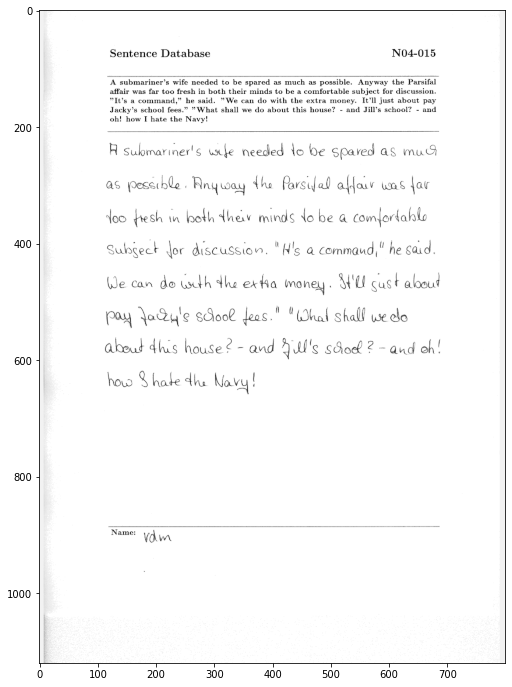

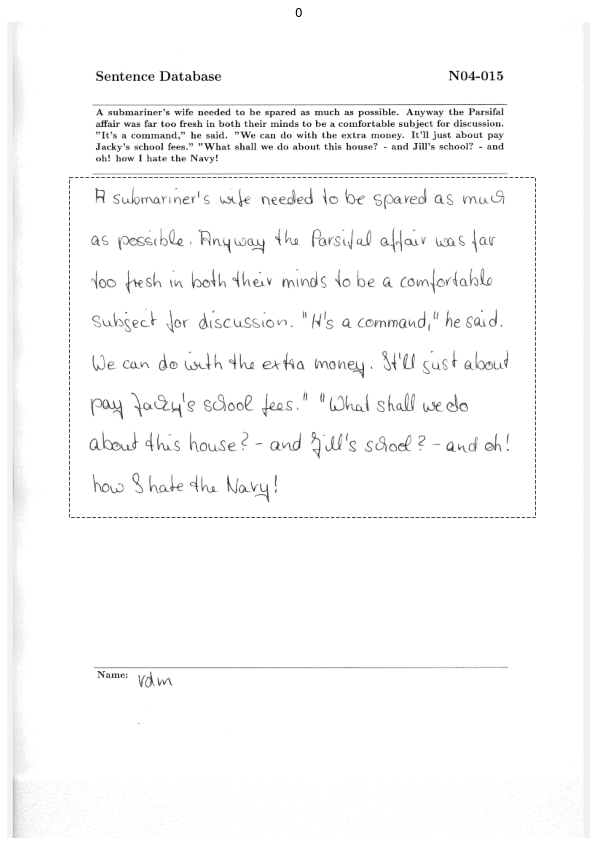

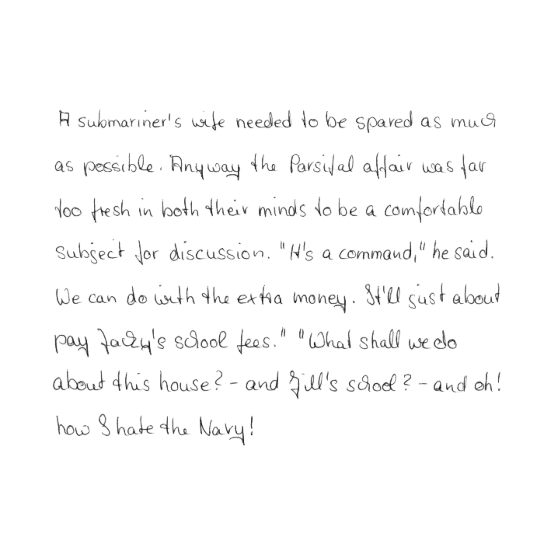

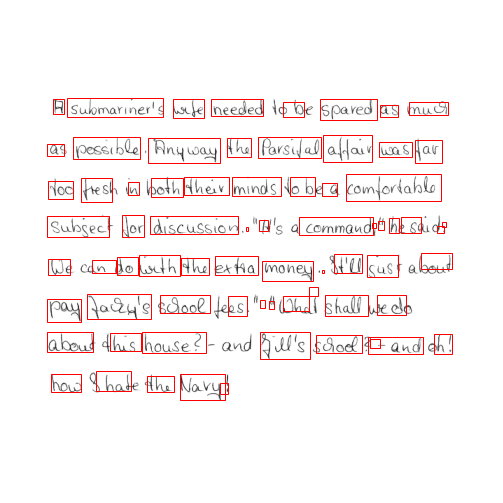

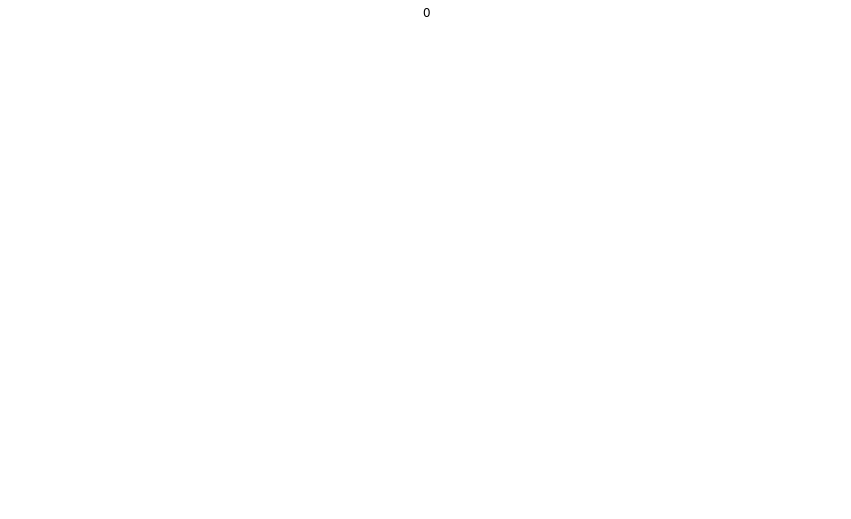

In [67]:
figs_to_plot = 1
images = []
n = 0
form_size = (1120, 800)
predicted_bbs = []


paragraph_segmented_images = []

# Required Variables for Word bb
min_c = 0.1
overlap_thres = 0.1
topk = 600

predicted_words_bbs_array = []

#Word to Line Variable declaration
line_images_array = []


for i in range(0, figs_to_plot):
    #n = int(random.random()*len(test_ds))
    n = 1
    image, _ = test_ds[n]
    images.append(image)
    im = Image.fromarray(image)
    image_path = "/content/drive/My Drive/handwritten-text-recognition-for-apache-mxnet/images/paragraph_image_"+str(i)+'.png'
    #im.save(image_path)
    #plot_paragraph(image)


plot_paragraph_boundingbox(images)
plot_paragraph_segmented(images)
plot_word_segmentation(images)
plot_word_to_line(images)

In [ ]:
#line_images_array

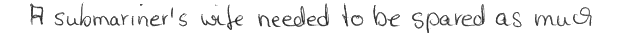

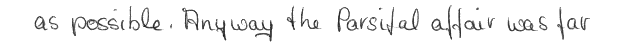

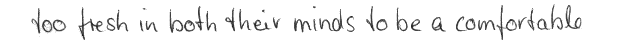

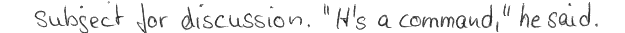

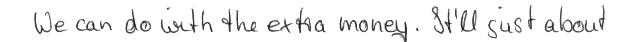

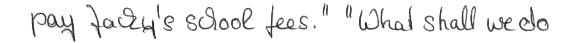

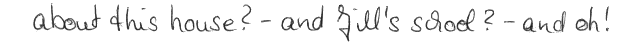

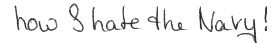

In [68]:
predict_line_text(line_images_array)
